In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

a: Converged after 4 iterations
b: Converged after 4 iterations
c: Converged after 4 iterations
d: Converged after 5 iterations
e: Converged after 4 iterations
f: Converged after 2 iterations
g: Converged after 3 iterations


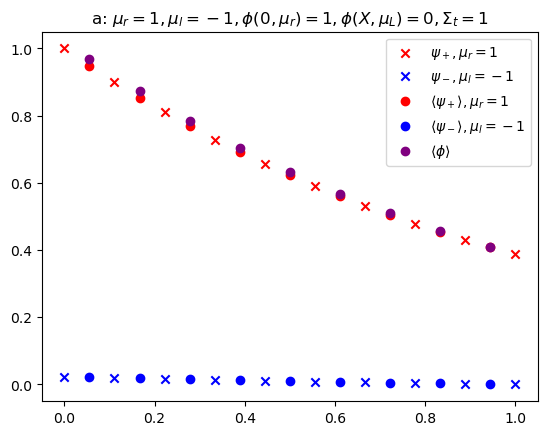

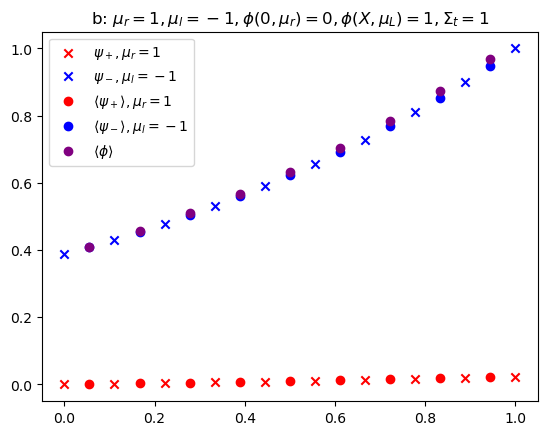

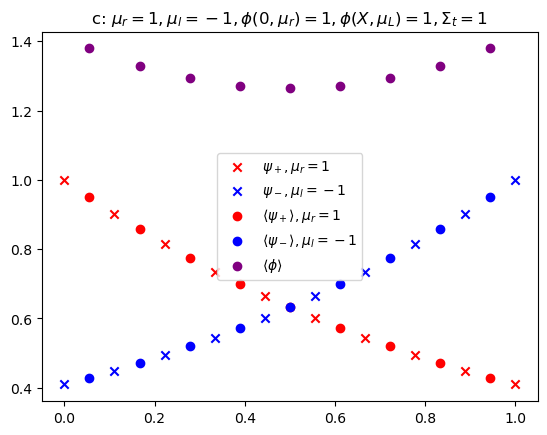

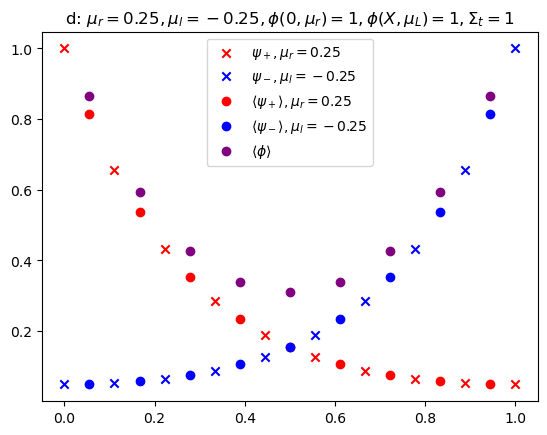

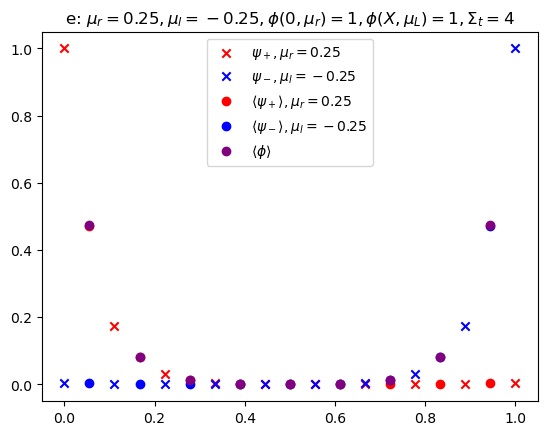

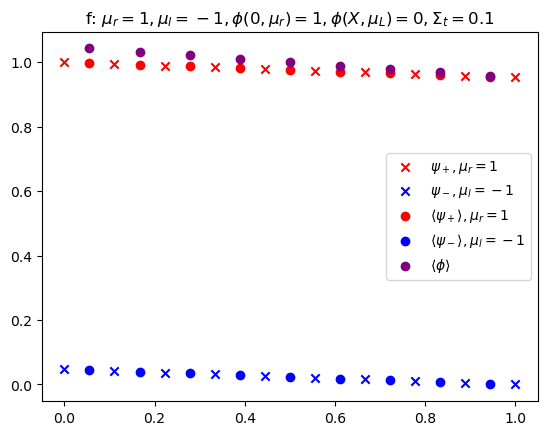

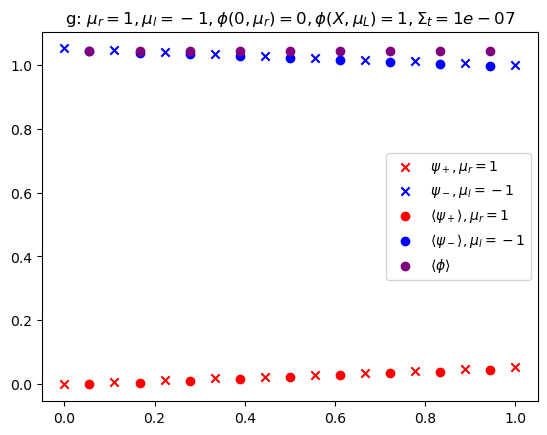

In [7]:
class AngularFlux:
    def __init__(
        self,
        mu_r,
        mu_l,
        phi_r,
        phi_l,
        sigma_t=1,
        sigma_s=0,
        title_start="",
        x_start=0,
        x_end=1,
        n_surfaces=10,
    ):
        self.mu_r = mu_r
        self.mu_l = mu_l
        self.phi_r = phi_r
        self.phi_l = phi_l
        self.title_start = title_start
        self.sigma_t = sigma_t
        self.sigma_s = sigma_s
        self.x_start = x_start
        self.x_end = x_end
        self.n_surfaces = n_surfaces
        self.n_cells = n_surfaces - 1

        assert x_start < x_end, "x_start must be less than x_end"
        assert mu_r != 0, "mu_r cannot be zero"
        assert mu_l != 0, "mu_l cannot be zero"

        self.surface_x = np.linspace(x_start, x_end, n_surfaces)
        delta_x = self.surface_x[1] - self.surface_x[0]
        self.cell_x = np.linspace(
            x_start + delta_x / 2, x_end - delta_x / 2, self.n_cells
        )

        self.rightward_angular_flux = np.zeros(n_surfaces)
        self.leftward_angular_flux = np.zeros(n_surfaces)

        self.rightward_average_angular_flux = np.zeros(self.n_cells)
        self.leftward_average_angular_flux = np.zeros(self.n_cells)
        self.average_scalar_flux = np.ones(self.n_cells)

    def angular_flux_one_direction(
        self,
        mu=1,
        psi_initial=1,
        # sigma_t=1, x_start=0, x_end=1, mu=1, psi_initial=1, n_surfaces=10
    ):

        x = self.surface_x
        delta_x = x[1] - x[0] if mu > 0 else x[0] - x[1]

        tau_coeff = self.sigma_t * delta_x / mu
        exp_term = np.exp(-tau_coeff)

        diag_index = -1 if mu > 0 else 1

        A = sp.sparse.diags(
            [1, -exp_term],
            [0, diag_index],
            shape=(self.n_surfaces, self.n_surfaces),
            format="csc",
        )

        cell_sources = [
            self.sigma_s / 2 * scalar_flux for scalar_flux in self.average_scalar_flux
        ]
        # TODO tau isn't constant for variable material properties
        scatter_source = [
            cell_source / self.sigma_t * (1 - exp_term) for cell_source in cell_sources
        ]

        if mu > 0:
            b_vec = [psi_initial] + scatter_source
        elif mu < 0:
            b_vec = scatter_source + [psi_initial]

        angular_flux_sol = sp.sparse.linalg.spsolve(A, b_vec)

        # calculate average
        A_coeff = lambda i: cell_sources[i] / self.sigma_t
        B_coeff = lambda xi, xe: mu / (self.sigma_t * (xi - xe))

        x_average = np.zeros(self.n_cells)
        flux_average = np.zeros(self.n_cells)
        for i in range(1, self.n_surfaces):
            x_left = x[i - 1]
            x_right = x[i]
            x_average[i - 1] = (x_left + x_right) / 2

            flux_left = angular_flux_sol[i - 1]
            flux_right = angular_flux_sol[i]
            flux_average[i - 1] = A_coeff(i - 1) + B_coeff(x_left, x_right) * (
                flux_right - flux_left
            )

        return angular_flux_sol, flux_average

    def angular_flux(self, max_iter=1000, tol=1e-6):
        # r and l mean going the flux is going in the right or left direction
        # so r corresponds to the left boundary

        for iter in range(max_iter):
            old_scalar_flux = self.average_scalar_flux.copy()

            (
                self.rightward_angular_flux,
                self.rightward_average_angular_flux,
            ) = self.angular_flux_one_direction(mu=self.mu_r, psi_initial=self.phi_r)

            self.leftward_angular_flux, self.leftward_average_angular_flux = (
                self.angular_flux_one_direction(mu=self.mu_l, psi_initial=self.phi_l)
            )

            self.average_scalar_flux = (
                self.leftward_average_angular_flux + self.rightward_average_angular_flux
            )

            if np.allclose(old_scalar_flux, self.average_scalar_flux, atol=tol):
                print(f"{self.title_start}: Converged after {iter} iterations")
                break

        fig, ax = plt.subplots()

        ax.scatter(
            self.surface_x,
            self.rightward_angular_flux,
            label=rf"$\psi_+, \mu_r = {self.mu_r}$",
            color="red",
            marker="x",
        )
        ax.scatter(
            self.surface_x,
            self.leftward_angular_flux,
            label=rf"$\psi_-, \mu_l = {self.mu_l}$",
            color="blue",
            marker="x",
        )

        ax.scatter(
            self.cell_x,
            self.rightward_average_angular_flux,
            label=rf"$\langle \psi_+ \rangle, \mu_r = {self.mu_r}$",
            color="red",
        )
        ax.scatter(
            self.cell_x,
            self.leftward_average_angular_flux,
            label=rf"$\langle \psi_- \rangle, \mu_l = {self.mu_l}$",
            color="blue",
        )
        ax.scatter(
            self.cell_x,
            self.average_scalar_flux,
            label=r"$\langle \phi \rangle$",
            color="purple",
        )

        ax.legend()

        ax.set_title(
            rf"{self.title_start}: $\mu_r = {self.mu_r}, \mu_l = {self.mu_l}, \phi(0,\mu_r) = {self.phi_r}, \phi(X,\mu_L) = {self.phi_l}, \Sigma_t = {self.sigma_t}$"
        )

        return fig, ax


sigma_s = 0.1
a = [1, -1, 1, 0, 1, sigma_s, "a"]
b = [1, -1, 0, 1, 1, sigma_s, "b"]
c = [1, -1, 1, 1, 1, sigma_s, "c"]
d = [0.25, -0.25, 1, 1, 1, sigma_s, "d"]
e = [0.25, -0.25, 1, 1, 4, sigma_s, "e"]
f = [1, -1, 1, 0, 0.1, sigma_s, "f"]
g = [
    1,
    -1,
    0,
    1,
    1e-7,
    sigma_s,
    "g",
]  # can't actually have Sigma_t = 0 because of division by zero

for i in [a, b, c, d, e, f, g]:
    AngularFlux(*i).angular_flux()
# AngularFlux(*c).angular_flux()